In [1]:
#Import packages
import pandas as pd
import numpy as np
import os

from functions import plotting_raw_data, error_plot, plot_cpt_data, plot_cpt_data_raw

import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import RepeatedKFold
from sklearn.metrics import r2_score
import xgboost as xgb

import optuna
from optuna.samplers import TPESampler
from optuna.visualization import plot_param_importances, plot_optimization_history

c:\Users\haris\Documents\GitHub\ISGSR25_DataDrivenSiteCharacterization\DataDriven\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
######################## Define the text size of each plot globally ###########
SMALL_SIZE = 10
BIGGER_SIZE = 10

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=SMALL_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

plt.rcParams["font.family"] = "Times New Roman"
######################## Define the text size of each plot globally ###########

In [3]:
# =============================================================================
# Import CPT Dataset
# =============================================================================

# File path
file_path = r"..\data\database_preprocessed_2024_CPT.csv"

# Read the CSV file into a DataFrame
df_raw = pd.read_csv(file_path, low_memory=False)

df_raw['fs (MPa)'] = df_raw['fs (MPa)'] * 1000
df_raw.rename(columns={'fs (MPa)': 'fs (kPa)'}, inplace=True)
df_raw.rename(columns={'depth (m)': 'Depth (m)'}, inplace=True)


# Select only SCPTu data
df_SCPTu = df_raw[df_raw['test type'] == 'SCPTu']
# Select only SCPT data
df_SCPT = df_raw[df_raw['test type'] == 'SCPT']
# Select both SCPTu and SPT data
df_SCPTu_SCPT = df_raw[(df_raw['test type'] == 'SCPTu') | (df_raw['test type'] == 'SCPT')]
df_SCPTu_SCPT_mean = df_raw[(df_raw['test type'] == 'SCPTu') | (df_raw['test type'] == 'SCPT')]

# Drop rows with missing Vs values
df_SCPTu_SCPT = df_SCPTu_SCPT.dropna(subset=['Vs (m/s)'])
df_SCPTu_SCPT_mean = df_SCPTu_SCPT_mean.dropna(subset=['Vs (m/s)'])

# count number of tests in both subsets
SCPTu_number = df_SCPTu['ID'].nunique()
SCPT_number = df_SCPT['ID'].nunique()
combined_number = df_SCPTu_SCPT['ID'].nunique()

print('Preprocessing:\n')
print('Number of tests in SCPTu =', SCPTu_number)
print('Number of tests in SCPT =', SCPT_number)
print('Number of tests in SCPTu and SCPT =', combined_number)

Preprocessing:

Number of tests in SCPTu = 217
Number of tests in SCPT = 46
Number of tests in SCPTu and SCPT = 263


In [4]:
# Select columns
selected_columns_x = ['Depth (m)','qc (MPa)', 'fs (kPa)','Rf (%)','Vs (m/s)'] #for Machine learning features
plot_columns_x_label = ['Depth (m)','$q_c$ (MPa)', '$f_s$ (kPa)','$R_f$ (%)', '$v_s$ (m/s)'] #for plotting purpose

In [5]:
df_SCPTu_SCPT

,Dataset,ID,Depth (m),test type,qc (MPa),fs (kPa),Rf (%),u2 (MPa),Vs (m/s)
220034,9,1101,0.50,SCPT,4.76,157.10,3.300420,NaN,200.00
220084,9,1101,1.00,SCPT,1.65,73.50,4.454545,NaN,107.00
220134,9,1101,1.50,SCPT,3.57,47.40,1.327731,NaN,53.00
220184,9,1101,2.00,SCPT,0.44,34.80,7.909091,NaN,56.00
220234,9,1101,2.50,SCPT,0.34,30.50,8.970588,NaN,61.00
...,...,...,...,...,...,...,...,...,...
2900715,11,YP0002,29.80,SCPTu,2.90,97.79,3.372069,-0.06511,258.26
2900716,11,YP0002,29.85,SCPTu,2.26,69.92,3.093805,-0.06439,258.26
2900717,11,YP0002,29.90,SCPTu,2.07,70.35,3.398551,-0.06387,258.26
2900718,11,YP0002,29.95,SCPTu,2.77,108.79,3.927437,-0.06346,258.26


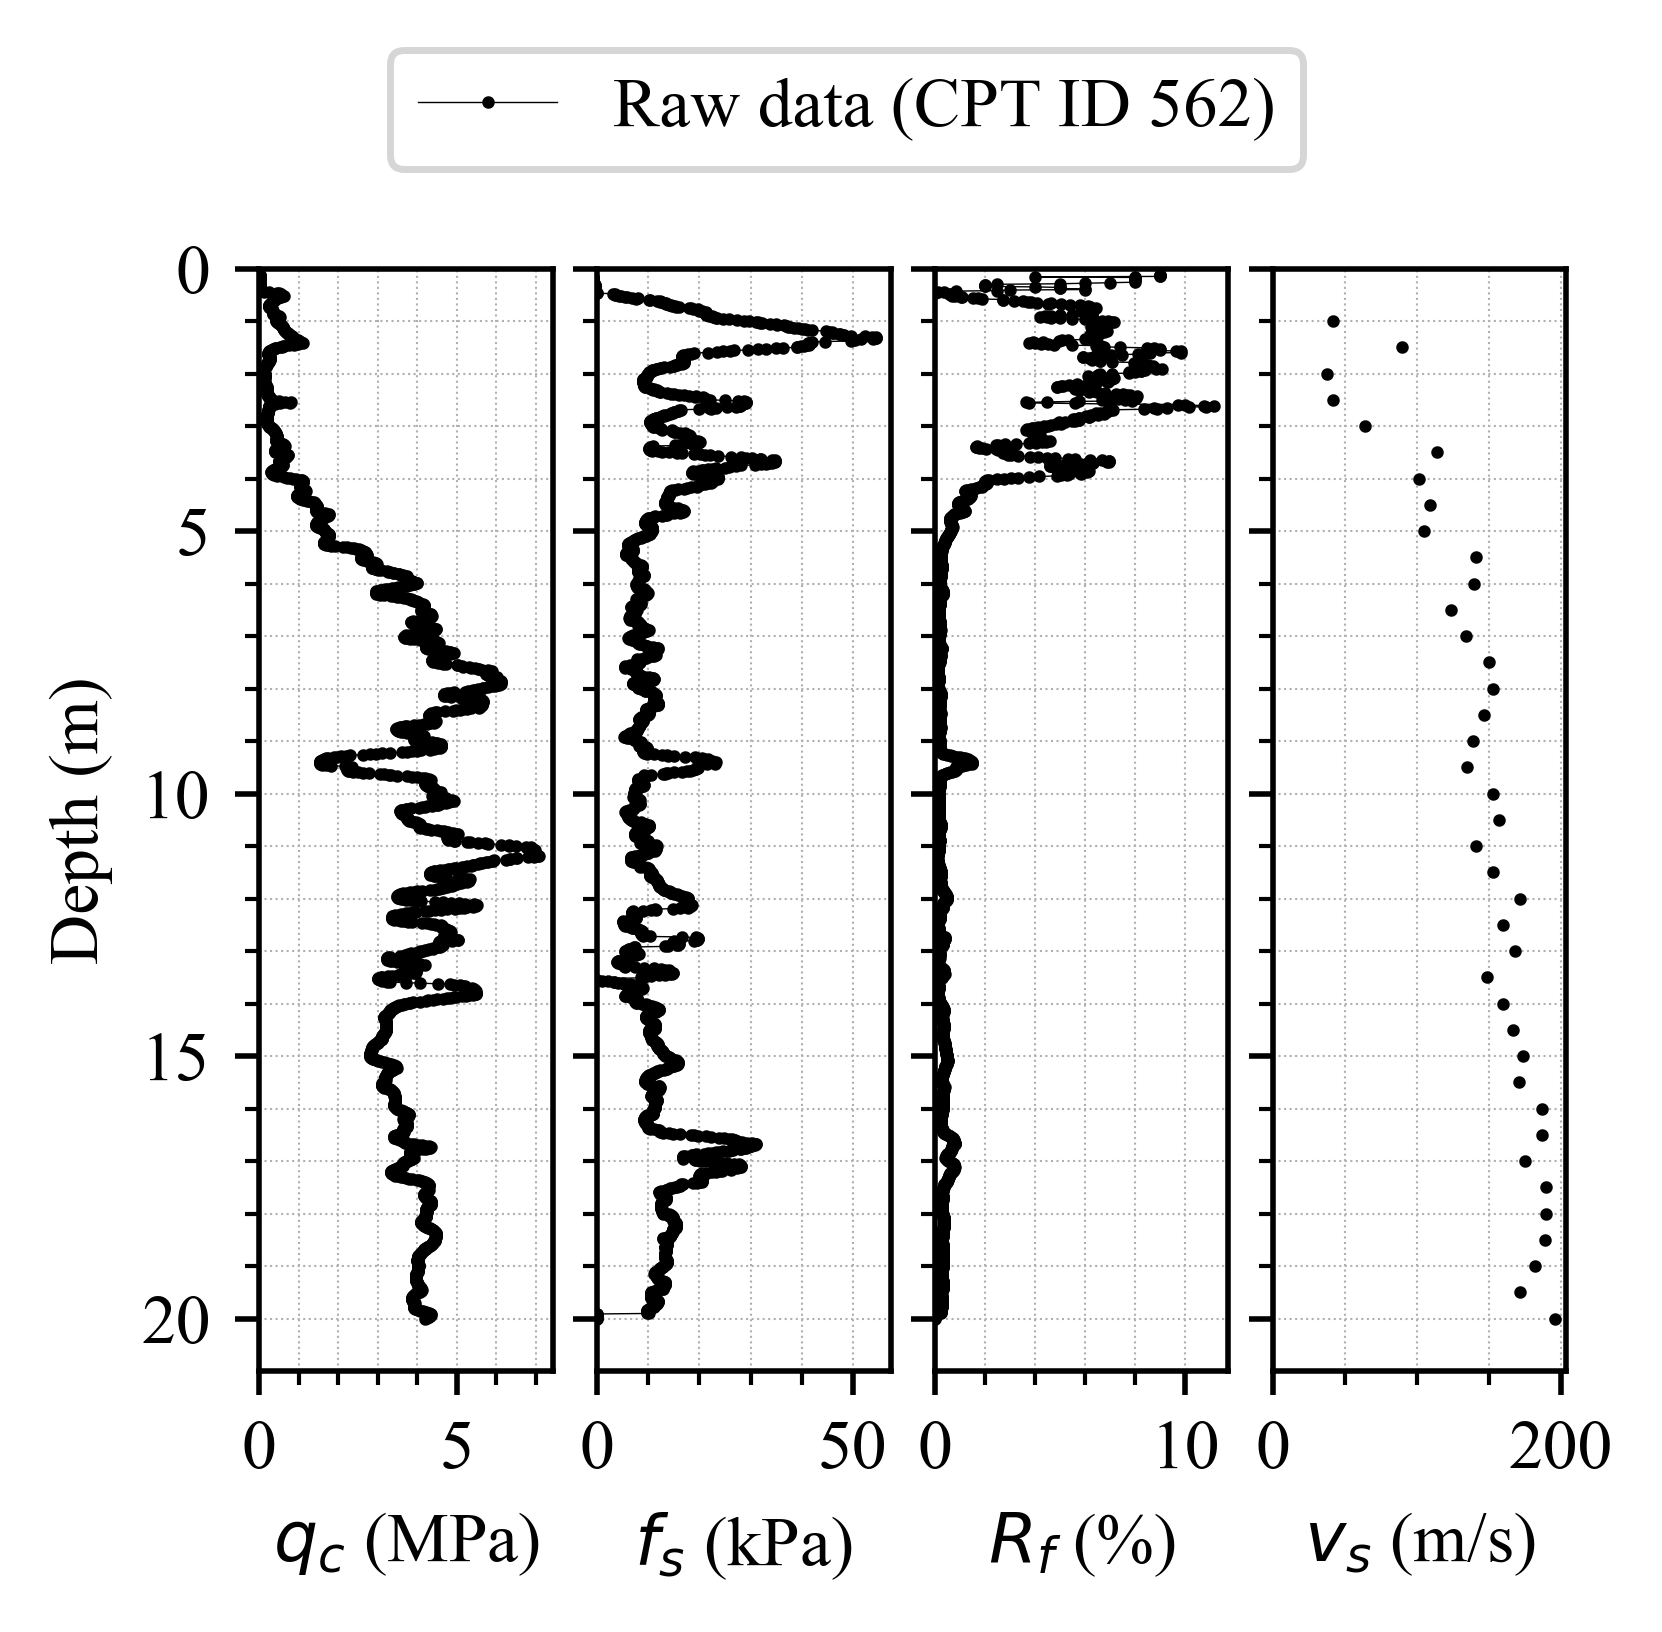

In [6]:
# =============================================================================
# Plotting the data and Selecting features
# =============================================================================
# Plotting CPT data 
cm = 1/2.54  # centimeters in inches

#Plot CPT: raw data and mean data
unique_ids = df_SCPTu_SCPT_mean.loc[:,'ID'].unique()
id_value = np.random.choice(unique_ids)
fig, axes = plot_cpt_data_raw((8*cm, 8*cm), selected_columns_x, df_raw,
              id_value=id_value,
              plot_columns_x_label=plot_columns_x_label, sort_column='Depth (m)')

axes[0].legend(loc='upper center', bbox_to_anchor=(2.0, 1.23), ncol=1, handlelength = 2, labelspacing=0.1)
plt.subplots_adjust(left=0.15, right=0.98, top=0.85, bottom=0.15, wspace=0.15, hspace=0.2)


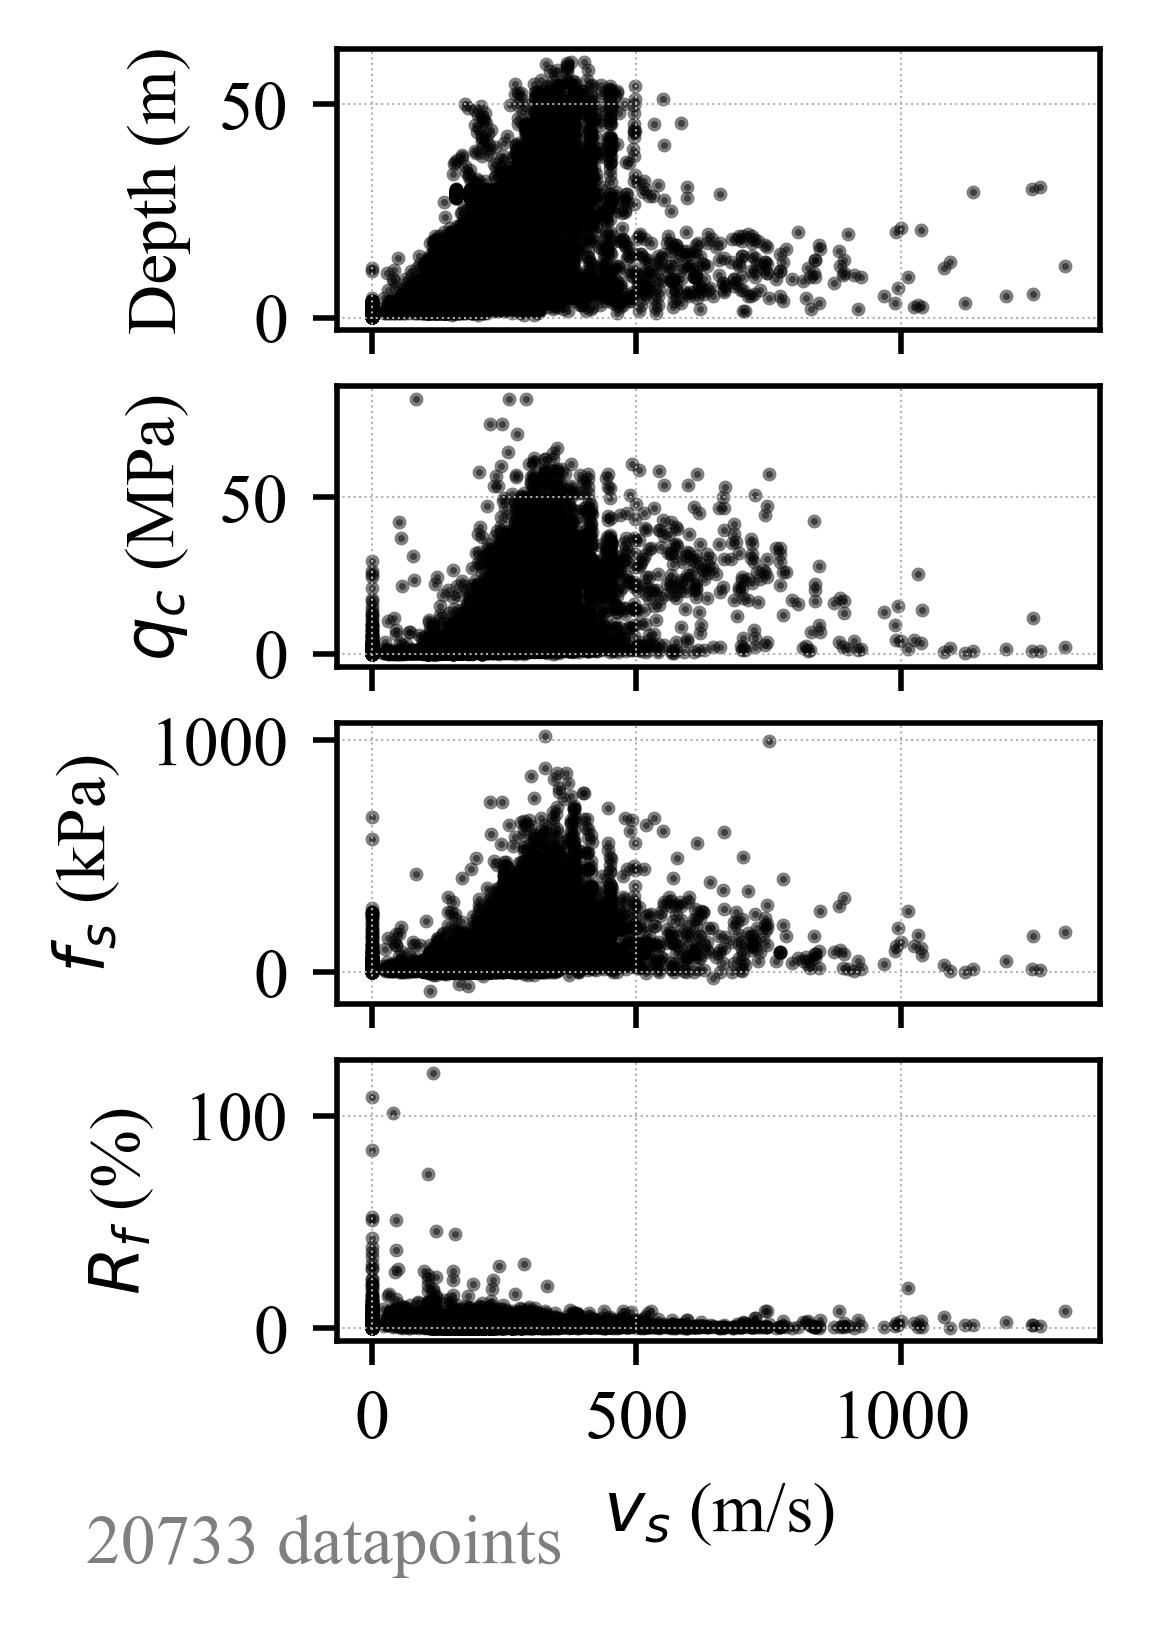

In [7]:
# Plotting training data 

X = df_SCPTu_SCPT[selected_columns_x[:-1]]#.to_numpy()
y = df_SCPTu_SCPT['Vs (m/s)']#.to_numpy()

s = 1  # Adjust the marker size as needed
color = 'k'  # Adjust the marker color as needed
alpha = 0.5

#Plot scatter points: raw data points as
fig, axes = plt.subplots(4, 1, figsize=(15.92/3*cm, 8*cm), dpi=500, sharex=True)
plotting_raw_data(X,y, alpha, s, color, True, axes, plot_columns_x_label, 'Raw data', False)

# Adjust layout to prevent overlapping
fig.text(0.01, 0.02, rf'{len(df_SCPTu_SCPT)} datapoints', ha='left', va='center', fontsize=10, color='black', alpha=0.5)
plt.subplots_adjust(left=0.25, right=0.98, top=0.97, bottom=0.15, wspace=0.15, hspace=0.2)
plt.savefig("..\\graphics\\10_Raw_data.png", dpi = 1000)

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [9]:
RS = 44  # random state
N_JOBS = -1  # number of parallel threads

# repeated K-folds
N_SPLITS = 10
N_REPEATS = 1

# Optuna
N_TRIALS = 200

# XGBoost
EARLY_STOPPING_ROUNDS = 10

In [ ]:
def objective(trial,
    X,
    y,
    random_state=22,
    n_splits=3,
    n_repeats=2,
    n_jobs=-1,
              ):
    
    param = {
        "objective": "reg:squarederror",
        "tree_method":'hist',
        'n_estimators': trial.suggest_int('n_estimators', 50, 150),
        "verbosity": 1,
        "learning_rate": trial.suggest_float("learning_rate", 0.05, 0.6, log=True),
        "max_depth": trial.suggest_int("max_depth", 3, 10),
        "subsample": trial.suggest_float("subsample", 0.05, 0.9,log=True),
        "n_jobs": n_jobs,
    }
    
    model = xgb.XGBRegressor(**param, eval_metric="rmse",early_stopping_rounds = EARLY_STOPPING_ROUNDS)
    rkf = RepeatedKFold(n_splits=n_splits, n_repeats=n_repeats, random_state=random_state)
    X_values = X.values
    y_values = y.values
    y_pred = np.zeros_like(y_values)

    for train_index, test_index in rkf.split(X_values):
        X_A, X_B = X_values[train_index, :], X_values[test_index, :]
        y_A, y_B = y_values[train_index], y_values[test_index]
        model.fit(X_A, y_A, eval_set=[(X_B, y_B)], verbose=0,)
        y_pred[test_index] += model.predict(X_B)
    y_pred /= n_repeats
    r2 = r2_score(y_true = y_train, y_pred = y_pred)
    
    return r2


sampler = TPESampler(seed=10)  # Make the sampler behave in a deterministic way.
study = optuna.create_study(sampler = sampler, direction='maximize')
study.optimize(
    lambda trial: objective(
        trial,
        X_train,
        y_train,
        random_state=RS,
        n_splits=N_SPLITS,
        n_repeats=N_REPEATS,
        n_jobs=N_JOBS,
    ),
    n_trials=N_TRIALS,
    n_jobs=N_JOBS,
)

[I 2024-11-20 21:34:22,948] A new study created in memory with name: no-name-038871d1-45f6-4015-9891-87b6d82512ed


[I 2024-11-20 21:34:24,453] Trial 7 finished with value: 0.5424043588435905 and parameters: {'n_estimators': 78, 'learning_rate': 0.4908798071070887, 'max_depth': 5, 'subsample': 0.13313561243191166}. Best is trial 7 with value: 0.5424043588435905.
[I 2024-11-20 21:34:24,655] Trial 3 finished with value: 0.5624508883673172 and parameters: {'n_estimators': 89, 'learning_rate': 0.5308394563885382, 'max_depth': 3, 'subsample': 0.4524951943323387}. Best is trial 3 with value: 0.5624508883673172.
[I 2024-11-20 21:34:25,153] Trial 0 finished with value: 0.5244970963590876 and parameters: {'n_estimators': 135, 'learning_rate': 0.4890733674068773, 'max_depth': 10, 'subsample': 0.2271416548973713}. Best is trial 3 with value: 0.5624508883673172.
[I 2024-11-20 21:34:25,290] Trial 6 finished with value: 0.5445828023112105 and parameters: {'n_estimators': 54, 'learning_rate': 0.2245763818027531, 'max_depth': 7, 'subsample': 0.06747333896050785}. Best is trial 3 with value: 0.5624508883673172.
[I 2

In [ ]:
# Plot optimization history
plot_optimization_history(study)

In [ ]:
# Plot parameter importances
plot_param_importances(study)

In [ ]:
hp = study.best_params

for key, value in hp.items():
    print(f"{key:>20s} : {value}")
print(f"{'best objective value':>20s} : {study.best_value}")

hp["verbosity"] = 0
hp["objective"] = "reg:squarederror"
hp["tree_method"] = "hist"
hp["seed"] = RS
hp["n_jobs"] = N_JOBS

        n_estimators : 106
       learning_rate : 0.05277240256469951
           max_depth : 10
           subsample : 0.3034713674271722
best objective value : 0.595411834016882


In [ ]:
model = xgb.XGBRegressor(**hp, eval_metric="rmse",early_stopping_rounds = EARLY_STOPPING_ROUNDS)
rkf = RepeatedKFold(n_splits=N_SPLITS, n_repeats=N_REPEATS, random_state=RS)
X_values = X_train.values
y_values = y_train.values
y_pred = np.zeros_like(y_test.values)
for train_index, test_index in rkf.split(X_values):
    X_A, X_B = X_values[train_index, :], X_values[test_index, :]
    y_A, y_B = y_values[train_index], y_values[test_index]
    model.fit(
        X_A,
        y_A,
        eval_set=[(X_B, y_B)],
        verbose=0,
    )
    y_pred += model.predict(X_test.values)
y_pred /= N_REPEATS * N_SPLITS

In [ ]:
score, mse = r2_score(y_true=y_test, y_pred=y_pred), mean_squared_error(y_true=y_test, y_pred=y_pred)

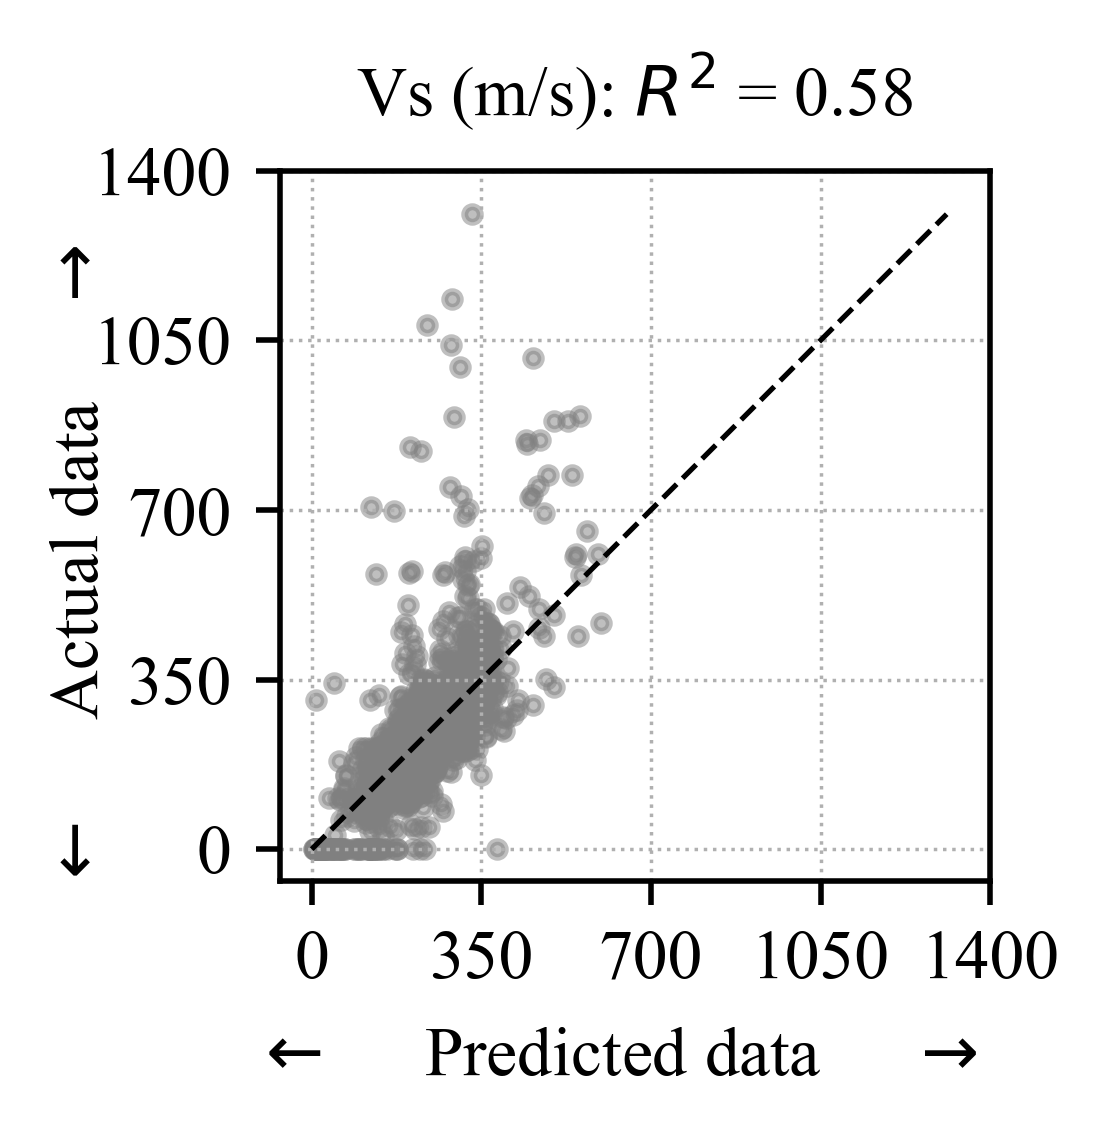

In [ ]:
from sklearn.metrics import PredictionErrorDisplay

figsize= (15.5/2*cm, 15.5/2*cm)
figsize=(15.92/3*cm, 15.92/3*cm)

y_true = y_test
y_pred = pd.DataFrame(y_pred)


# Define plot structure
fig, axs = plt.subplots(nrows=1, ncols=1, figsize=figsize, dpi=500)

ped = PredictionErrorDisplay.from_predictions(y_true=y_true,
                                            y_pred=y_pred,
                                            kind="actual_vs_predicted",
                                            subsample=100000,
                                            ax=axs,
                                            random_state=0, 
                                            line_kwargs={"color": "black", "linewidth": 0.75, "linestyle": "--", "alpha": 1},)

ped.ax_.set_xlabel("")  # Set x label
ped.ax_.set_ylabel("")  # Set y label

xlim, ylim = 0,1400

ped.ax_.set_xticks(np.arange(xlim, ylim+0.001, (ylim-xlim)/4))
ped.ax_.set_yticks(np.arange(xlim, ylim+0.001, (ylim-xlim)/4))
# ped.ax_.set_xlim(xlim+0.001, ylim-0.001)
# ped.ax_.set_ylim(xlim+0.001, ylim-0.001)


ped.ax_.grid(linewidth = 0.5, linestyle = 'dotted')

scatter = ped.figure_.axes[0].collections[0]
scatter.set_color('black')  
scatter.set_sizes([5]) 
scatter.set_alpha([0.5]) 

# plt.title(f'{investigated_column_plot}: $R^2$ = {score:.2f}, $MSE$ = {mse:.2f}', x = 0.41, y=1.02)
plt.title(f'{selected_columns_x[-1]}: $R^2$ = {score:.2f}', x = 0.5, y=1.02)


ax = ped.ax_
ax.set_xticks(ax.get_xticks())
ax.tick_params(axis='x', rotation=0)

fig.text(0.55, 0.03, r'$\leftarrow$     Predicted data     $\rightarrow$', ha='center', va='center')
fig.text(0.04, 0.5, r'$\leftarrow$     Actual data     $\rightarrow$', ha='center', va='center', rotation='vertical')

plt.subplots_adjust(left=0.23, right=0.91, top=0.88, bottom=0.20, wspace=0.5, hspace=0.5)

save_path = r'..\graphics\\10_vs_prediction.png'
plt.savefig(save_path, dpi=1000)

In [ ]:
# Save the model using joblib or pickle
import joblib

# Fit the model on the entire dataset with the best hyperparameters
final_model = xgb.XGBRegressor(**hp, eval_metric="rmse", random_state=RS)

# Fit the model on the entire dataset
final_model.fit(X, y)

joblib.dump(final_model, f'10_vs_prediction_xgb_model.joblib')


['10_vs_prediction_xgb_model.joblib']